# Decision Tree & Random Forest

이 글은 인사이트 캠퍼스의 조성현 강사님의 강의를 수강하며 정리한 자료입니다. [조성현 강사님 블로그 바로가기](https://blog.naver.com/chunjein)

## Decision Tree

![image-20200718234831922](markdown-images/image-20200719074811654.png)

- 직선 혹은 (초)평면으로 데이터를 분류하는 분류 알고리즘

- 경계를 많이 사용하면 과잉적합의 우려가 있다. 따라서 정지기준, 사전/사후 가지치기 방법이 사용된다.
  - 정지기준: 트리의 깊이 지정, 마지막 노드의 데이터 수 일정 수준이하로 떨어지지 않도록 지정
  - 가지치기: 트리를 단순화시킨다.
    - 사전 가지치기: 조기 정지규칙에 의해 트리 성장을 멈춤
    - 사후 가지치기: 초기에 트리를 최대크기로 만들고, Trimming을 통해 복잡도를 줄여나간다.

- 분류나 예측의 근거를 알 수 있으므로 쉽게 이해 가능

- Feature마다 분류에 영향을 미치는 정도를 파악할 수 있다.

  

### 의사결정선 결정하기

- 분할 전 부모 노드의 불순척도보다 분할 후 자식 노드의 불순척도가 낮을수록 좋다. -> 여러 분할을 시도하고 불순도가 가장 낮은 경계로 분할한다.

- 불순척도

  - 엔트로피(0~1의 값)
    $$
    H(t) = -\sum\limits_{i=1}^c{p(i|t)log_2p(i|t)}
    $$

  - 지니 지수(0~0.5의 값)
    $$
    Gini(t) = 1-\sum\limits_{i=1}^cp(i|t)^2
    $$
    



#### 1. Pre-pruning(사전 가지치기) - depth로 최적화

- 트리의 깊이를 변화시켜가면서 test데이터의 정확도를 측정, 가장 높은 깊이를 찾아 최종 Decision Tree로 사용

```python
for k in range(1,20):
    dt = DecisionTreeClassifier(criterion = 'gini', max_depth = k)
    dt.fit(trainX, trainY)
    
    trainGini.append((dt.predict(trainX)==trainY).mean())
    testGini.append((dt.predict(testX)==testY).mean())
    
    dt = DecisionTreeClassifier(criterion ='entropy', max_depth = k)
    dt.fit(trainX, trainY)
    
    trainEntropy.append(dt.score(trainX,trainY))
    testEntropy.append(dt.score(testX,testY))
```

![image-20200719074811654](markdown-images/image-20200719074811654.png)

- test dataset으로 측정한 정확도가 낮아지는 k=7 근처로 트리의 깊이를 지정한다.



#### 2. Post-pruning(사후 가지치기) - α로 최적화

- 최대한 복잡하게 트리를 구성한 뒤, 에러가 작아지는 방향으로 가지치기를 수행.

- $$
  오분류율: e_a(T) = \frac{e+N*α}D
  $$

  - **<u>오분류율에 패널티항(α)을 추가하고 leaf-node가 많아질 수록 패널티를 크게 부여한다.</u>**
    - e: 잘못 분류된 개수(leaf-node의 숫자가 작은 것)
    - N: leaf-node개수
    - D: data 개수

- 즉, α=0부터 무한대까지 관찰하며 최적의 알파를 찾는다.

```python
path = DecisionTreeClassifier().cost_complexity_pruning_path(trainX, trainY)
#이 함수는 학습데이터에 대해서 내부적으로 알파값을 변화시켜가면서 트리를 만들고 에러를 측정한다.
#path에 impurities(불순도)와 alpha(패널티)가 리턴된다.

ccp_alphas, impurities = path.ccp_alphas, path.impurities

path
>>>
{'ccp_alphas': array([ 0.00000000e+00, -2.71050543e-20,  0.00000000e+00, ...,
         1.56445662e-02,  2.65423192e-02,  6.05744854e-02]),
 'impurities': array([0.03445308, 0.03445308, 0.03445308, ..., 0.28040352, 0.30694584,
        0.36752033])}

clfs = []
for i, ccp_alpha in enumerate(ccp_alphas):
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(trainX, trainY)
    clfs.append(clf)
        
    print('%d) ccp_alphas = %.4f done.' % (i, ccp_alpha))

print('마지막 tree의 노드 개수 = %d' % clfs[-1].tree_.node_count)
print('마지막 tree의 alpha = %.4f' % ccp_alphas[-1])
print('마지막 tree의 depth = %d' % clfs[-1].tree_.max_depth)

>>>
마지막 tree의 노드 개수 = 3
마지막 tree의 alpha = 0.0265
마지막 tree의 depth = 1

# clfs는 앞 부분 n개만 사용한다. 뒷 부분은 alpha가 너무 크기 때문에 제외한다.
# test_scores[:n]중 가장 큰 최적 alpha를 찾는다.
opt_alpha = ccp_alphas[np.argmax(test_scores[:n])]

# opt_alpha를 적용한 tree를 사용한다.
dt = DecisionTreeClassifier(ccp_alpha=opt_alpha)
dt.fit(trainX, trainY)
```



### Feature importrance

- Decision Tree는 하위 tree의 양쪽 불순도가 최소가 되도록 분기를 결정한다. 분기를 완료한 뒤, feature별로 얼마나 불순도를 감소시켰는지 평균감소율을 계산해 feature들의 중요도를 판단할 수 있다.

```python
feature_importance = dt.feature_importances_
feature_name = list(income.columns)
n_feature = trainX.shape[1]
idx = np.arange(n_feature)
```



# Random Forest
- 중복허용, 균등분포로 n개의 서브 데이터를 샘플링하고, 각 서브 데이터마다 Decision Tree를 구축한다.
- 서브 데이터는 랜덤하게 추출되므로 서브트리들은 약간씩 다르게 구성된다.
    - 분산  감소, 일반화 특성 향상

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# iris 데이터를 읽어온다.
iris = load_iris()

# Train 데이터 세트와 Test 데이터 세트를 구성한다
trainX, testX, trainY, testY = \
    train_test_split(iris['data'], iris['target'], test_size = 0.2)

rf = RandomForestClassifier(max_depth=5, n_estimators=100)
rf.fit(trainX, trainY)

# 학습데이터와 시험데이터의 정확도를 측정한다.
print('\n학습데이터의 정확도 = %.2f' % rf.score(trainX, trainY))
print('시험데이터의 정확도 = %.2f' % rf.score(testX, testY))

# 시험데이터의 confusion matrix를 작성한다 (row : actual, col : predict)
predY = rf.predict(testX)
print('\nConfusion matrix :')
print(confusion_matrix(testY, predY))
print()
print(classification_report(testY, predY, target_names=iris.target_names))

# Sub tree별 시험데이터의 정확도를 확인한다.
print('\nSubtree별 시험데이터 정확도 :')
for i in range(100):
    subTree = rf.estimators_[i]
    print('subtree (%d) = %.2f' % (i, subTree.score(testX, testY)))

# classification_report()를 해석해 본다.
import numpy as np
label = np.vstack([testY, predY]).T

# class = n이라고 예측한 것 중 실제 classe=n인 비율
def precision(n):
    y = label[label[:, 1] == n]
    match = y[y[:, 0] == y[:, 1]]
    return match.shape[0] / y.shape[0]

print()
print('class-0 precision : %.2f' % precision(0))
print('class-1 precision : %.2f' % precision(1))
print('class-2 precision : %.2f' % precision(2))

# 실제 class = n인 것중 classe=n으로 예측한 비율
def recall(n):
    y = label[label[:, 0] == n]
    match = y[y[:, 0] == y[:, 1]]
    return match.shape[0] / y.shape[0]

print()
print('class-0 recall : %.2f' % recall(0))
print('class-1 recall : %.2f' % recall(1))
print('class-2 recall : %.2f' % recall(2))

# F1-score
def f1_score(n):
    p = precision(n)
    r = recall(n)
    return 2 * p * r / (p + r)

print()
print('class-0 f1-score : %.2f' % f1_score(0))
print('class-1 f1-score : %.2f' % f1_score(1))
print('class-2 f1-score : %.2f' % f1_score(2))


학습데이터의 정확도 = 1.00
시험데이터의 정확도 = 0.93

Confusion matrix :
[[11  0  0]
 [ 0  5  0]
 [ 0  2 12]]

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        11
  versicolor       0.71      1.00      0.83         5
   virginica       1.00      0.86      0.92        14

    accuracy                           0.93        30
   macro avg       0.90      0.95      0.92        30
weighted avg       0.95      0.93      0.94        30


Subtree별 시험데이터 정확도 :
subtree (0) = 0.97
subtree (1) = 0.97
subtree (2) = 0.93
subtree (3) = 0.97
subtree (4) = 0.97
subtree (5) = 0.93
subtree (6) = 0.83
subtree (7) = 0.93
subtree (8) = 0.93
subtree (9) = 0.93
subtree (10) = 0.97
subtree (11) = 0.90
subtree (12) = 0.90
subtree (13) = 0.93
subtree (14) = 1.00
subtree (15) = 1.00
subtree (16) = 0.97
subtree (17) = 1.00
subtree (18) = 0.97
subtree (19) = 0.97
subtree (20) = 0.93
subtree (21) = 1.00
subtree (22) = 1.00
subtree (23) = 0.97
subtree (24) = 0.90
subtree (25)

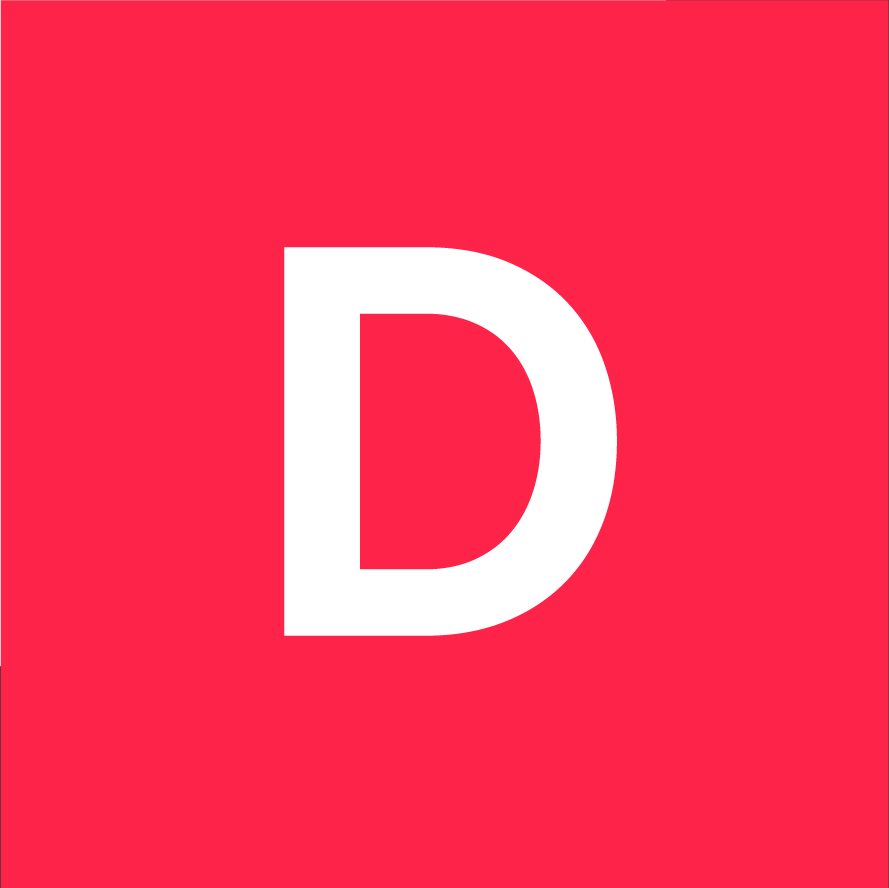